<a href="https://colab.research.google.com/github/KingChad127/fri_final_project/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 27 09:03:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |  14860MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!git clone https://github.com/KingChad127/fri_final_project

fatal: destination path 'fri_final_project' already exists and is not an empty directory.


In [3]:
%cd fri_final_project/

/content/fri_final_project


In [4]:
# !pip install -r requirements.txt
!pwd

/content/fri_final_project


In [5]:
import os
import sys
from mrcnn import utils

ROOT_DIR = os.path.abspath("./")


sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [6]:
from mrcnn.config import Config

class ElevatorPanelConfig(Config):
    NAME = "elevator_panel"

    IMAGES_PER_GPU = 2

    NUM_CLASSES = 1 + 2

    STEPS_PER_EPOCH = 100

    DETECTION_MIN_CONFIDENCE = 0.9

In [7]:
config = ElevatorPanelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
import matplotlib
import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
import json
import skimage.draw
import numpy as np

class ElevatorPanelDataset(utils.Dataset):

    def load_elevator(self, dataset_dir, subset):
        # add classes
        self.add_class("elevator_panel", 1, "label")
        self.add_class("elevator_panel", 2, "button")
        self.add_class("elevator_panel", 3, "label_and_button")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "masks.json")))
        annotations = list(annotations.values())

        # skip images that have an empty region key
        # aka images with no annotations
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes']
                            for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            ids = []
            for region in a["regions"]:
                # if len(region["region_attributes"]["Elevator Item"]) == 2:
                #     class_id = 3
                # else:
                ei = region["region_attributes"]["Elevator Item"]
                if "Button" in ei and ei["Button"]:
                    class_id = 2
                else:
                    class_id = 1
                # class_id = 1 if 'Label' in ei else 2
                ids.append(class_id)

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "elevator_panel",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                ids=ids)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        # print(image_info)
        polygons = image_info["polygons"]
        count = len(polygons)
        if image_info["source"] != "elevator_panel":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]

        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], count],
                        dtype=np.uint8)

        # print('img height: ', info['height'])
        # print('img width: ', info['width'])

        for i, p in enumerate(polygons):
            # Get indexes of pixels inside the polygon and set them to 1
            # print(p)
            if p["name"] == "circle":
                rr, cc = skimage.draw.circle(r=p['cy'], c=p['cx'], radius=p['r'])
            elif p["name"] == "rect":
                start = (p['y'], p['x'])
                extent = (p['height'], p['width'])
                rr, cc = skimage.draw.rectangle(start=start, extent=extent)
            elif p["name"] == "ellipse":
                rr, cc = skimage.draw.ellipse(r=p['cy'], c=p['cx'], r_radius=p['ry'], c_radius=p[
                    'rx'], rotation=np.deg2rad(p['theta']))
            else:
                rr, cc = skimage.draw.polygon(
                    r=p['all_points_y'], c=p['all_points_x'])

            mask[rr, cc, i] = 1

        class_ids = np.array(image_info["ids"], dtype=np.int32)
        # print(class_ids)

        # np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "elevator_panel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
# Training dataset
dataset_train = ElevatorPanelDataset()
dataset_train.load_elevator("elevator_panels", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ElevatorPanelDataset()
dataset_val.load_elevator("elevator_panels", "val")
dataset_val.prepare()

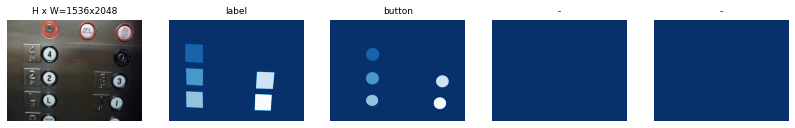

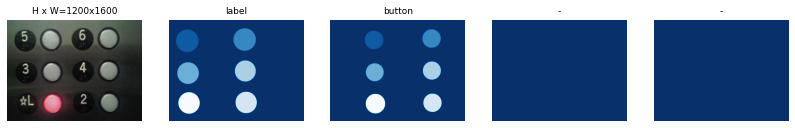

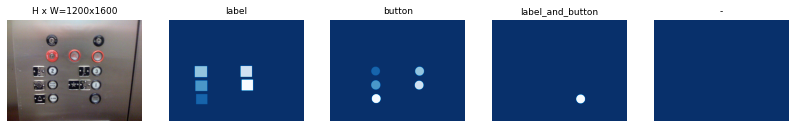

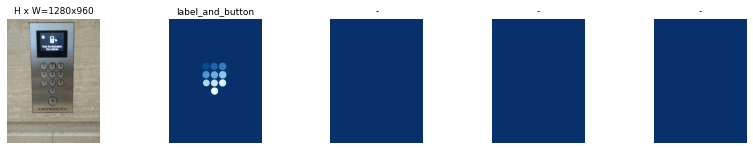

In [11]:
# Load and display random samples
from mrcnn import visualize

image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [21]:
# Create model in training mode
import mrcnn.model as modellib

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [22]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [23]:
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='heads')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/fri_final_project/logs/elevator_panel20220427T1507/mask_rcnn_elevator_panel_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_m

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
 99/100 [============================>.] - ETA: 0s - loss: 1.7344 - rpn_class_loss: 0.1003 - rpn_bbox_loss: 0.3165 - mrcnn_class_loss: 0.5558 - mrcnn_bbox_loss: 0.4411 - mrcnn_mask_loss: 0.3207

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



100/100 [==============================] - 306s 3s/step - loss: 1.7283 - rpn_class_loss: 0.0994 - rpn_bbox_loss: 0.3142 - mrcnn_class_loss: 0.5539 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.3210 - val_loss: 0.6497 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.0952 - val_mrcnn_class_loss: 0.3062 - val_mrcnn_bbox_loss: 0.1338 - val_mrcnn_mask_loss: 0.1090
Epoch 2/30
100/100 [==============================] - 136s 1s/step - loss: 0.9384 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.3161 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.2139 - val_loss: 0.7087 - val_rpn_class_loss: 0.0062 - val_rpn_bbox_loss: 0.1078 - val_mrcnn_class_loss: 0.3881 - val_mrcnn_bbox_loss: 0.1231 - val_mrcnn_mask_loss: 0.0834
Epoch 3/30
100/100 [==============================] - 133s 1s/step - loss: 0.8174 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.1649 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.2034 - val_loss: 0.8815 - val_rpn_class_loss: 0.005

In [34]:
class InferenceConfig(ElevatorPanelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, "elevator_panels/mask_rcnn_elevator_panel_0001.h5")
model_path = os.path.join(ROOT_DIR, "elevator_panels/mask_rcnn_elevator_panel_0030.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/fri_final_project/elevator_panels/mask_rcnn_elevator_panel_0030.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 4032.00000  float64
gt_class_id              shape: (16,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (16, 4)               min:  128.00000  max:  862.00000  int32
gt_mask                  shape: (1024, 1024, 16)      min:    0.00000  max:    1.00000  bool


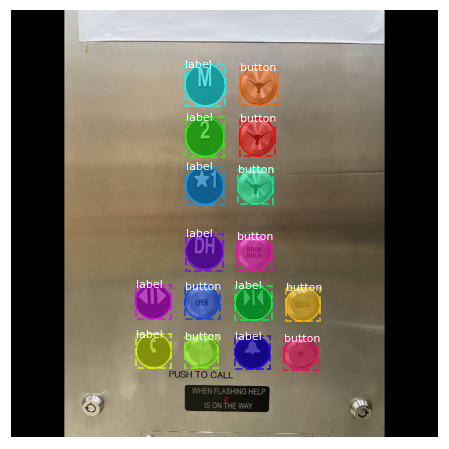

In [29]:
# Test on a random image
import random
from mrcnn.model import log

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


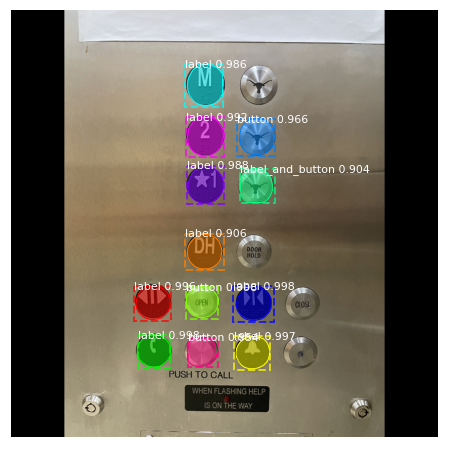

In [35]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [39]:
!git config user.email "abhinav.chadaga@utexas.edu"
!git config user.name "KingChad127"
!git add -A
!git commit -m "First round of results"
!git push remote https://github.com/KingChad127/fri_final_project.git

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: remote part of refspec is not a valid name in https://github.com/KingChad127/fri_final_project.git
